# Event-aligned spike time analysis

## Setup

First, let's change directories to find the `dj_local_conf` file.

In [1]:
import os
if os.path.basename(os.getcwd()) == "notebooks": os.chdir("..")

In [2]:
# We'll be working with long tables, so we'll make visualization easier with a limit
import datajoint as dj
dj.config["display.limit"] = 10

Next, we populate the python namespace with the required schemas

In [3]:
from workflow_array_ephys.pipeline import session, ephys, trial, event, analysis

[2022-09-15 10:14:05,277][INFO]: Connecting cbroz@tutorial-db.datajoint.io:3306
[2022-09-15 10:14:05,749][INFO]: Connected cbroz@tutorial-db.datajoint.io:3306


## Trial and Event schemas

Tables in the `trial` and `event` schemas specify the structure of your experiment, including block, trial and event timing.
- Session has a 1-to-1 mapping with a behavior recording
- A block is a continuous phase of an experiment that contains repeated instances of a condition, or trials.
- Events may occur within or outside of conditions, either instantaneous or continuous.

The diagram below shows (a) the levels of hierarchy and (b) how the bounds may not completely overlap. A block may not fully capture trials and events may occur outside both blocks/trials.

```
|----------------------------------------------------------------------------|
|-------------------------------- Session ---------------------------------|__
|-------------------------- BehaviorRecording -----------------------------|__
|----- Block 1 -----|______|----- Block 2 -----|______|----- Block 3 -----|___
| trial 1 || trial 2 |____| trial 3 || trial 4 |____| trial 5 |____| trial 6 |
|_|e1|_|e2||e3|_|e4|__|e5|__|e6||e7||e8||e9||e10||e11|____|e12||e13|_________|
|----------------------------------------------------------------------------|
```

Let's load some example data. The `ingest.py` script has a series of loaders to help.

In [4]:
from workflow_array_ephys.ingest import (
    ingest_subjects,
    ingest_sessions,
    ingest_events,
    ingest_alignment,
)

In [5]:
ingest_subjects()
ingest_sessions()
ingest_events()


---- Insert 0 entry(s) into subject.Subject ----

---- Successfully completed ingest_subjects ----

---- Insert 0 entry(s) into session.Session ----

---- Insert 0 entry(s) into probe.Probe ----

---- Insert 0 entry(s) into ephys.ProbeInsertion ----

---- Successfully completed ingest_subjects ----

---- Inserting 1 entry(s) into behavior_recording ----

---- Inserting 2 entry(s) into behavior_recording__file ----

---- Inserting 4 entry(s) into _block ----

---- Inserting 4 entry(s) into _block__attribute ----

---- Inserting 2 entry(s) into #trial_type ----

---- Inserting 100 entry(s) into _trial ----

---- Inserting 100 entry(s) into _trial__attribute ----

---- Inserting 100 entry(s) into _block_trial ----

---- Inserting 3 entry(s) into #event_type ----

---- Inserting 153 entry(s) into _event ----

---- Inserting 153 entry(s) into _trial_event ----


We have 100 total trials, either 'stim' or 'ctrl', with start and stop time

In [6]:
trial.Trial()

subject,session_datetime,trial_id trial number (1-based indexing),trial_type,trial_start_time (second) relative to recording start,trial_stop_time (second) relative to recording start
subject6,2021-01-15 11:16:38,1,stim,0.123,17.123
subject6,2021-01-15 11:16:38,2,ctrl,17.54,34.54
subject6,2021-01-15 11:16:38,3,ctrl,34.81,51.81
subject6,2021-01-15 11:16:38,4,ctrl,52.202,69.202
subject6,2021-01-15 11:16:38,5,stim,69.611,86.611
subject6,2021-01-15 11:16:38,6,stim,87.03,104.03
subject6,2021-01-15 11:16:38,7,ctrl,104.165,121.165
subject6,2021-01-15 11:16:38,8,ctrl,121.502,138.502
subject6,2021-01-15 11:16:38,9,ctrl,138.612,155.612
subject6,2021-01-15 11:16:38,10,stim,155.741,172.741


Each trial is paired with events that take place during the trial window.

In [7]:
trial.TrialEvent() & "trial_id<5"

subject,session_datetime,trial_id trial number (1-based indexing),event_type,event_start_time (second) relative to recording start
subject6,2021-01-15 11:16:38,1,center,10.58
subject6,2021-01-15 11:16:38,2,center,21.647
subject6,2021-01-15 11:16:38,3,center,37.044
subject6,2021-01-15 11:16:38,4,center,55.259
subject6,2021-01-15 11:16:38,1,left,4.498
subject6,2021-01-15 11:16:38,3,left,41.892
subject6,2021-01-15 11:16:38,2,right,23.9


Finally, the `AlignmentEvent` describes the event of interest and the window we'd like to see around it.

In [8]:
ingest_alignment()


---- Inserting 3 entry(s) into alignment_event ----


In [9]:
event.AlignmentEvent()

alignment_name,alignment_description,alignment_event_type,alignment_time_shift (s) WRT alignment_event_type,start_event_type,start_time_shift (s) WRT start_event_type,end_event_type,end_time_shift (s) WRT end_event_type
center_button,,center,0.0,center,-3.0,center,3.0
left_button,,left,0.0,left,-3.0,left,3.0
right_button,,right,0.0,right,-3.0,right,3.0


## Event-aligned spike times

First, we'll check that the data is still properly inserted from the previous notebooks.

In [10]:
ephys.CuratedClustering()

subject,session_datetime,insertion_number,paramset_idx
subject6,2021-01-15 11:16:38,0,0


For this example, we'll be looking at `subject6`.

In [11]:
clustering_key = (
    ephys.CuratedClustering
    & {
        "subject": "subject6",
        "session_datetime": "2021-01-15 11:16:38",
        "insertion_number": 0,
    }
).fetch1("KEY")

In [12]:
trial.Trial & clustering_key

subject,session_datetime,trial_id trial number (1-based indexing),trial_type,trial_start_time (second) relative to recording start,trial_stop_time (second) relative to recording start
subject6,2021-01-15 11:16:38,1,stim,0.123,17.123
subject6,2021-01-15 11:16:38,2,ctrl,17.54,34.54
subject6,2021-01-15 11:16:38,3,ctrl,34.81,51.81
subject6,2021-01-15 11:16:38,4,ctrl,52.202,69.202
subject6,2021-01-15 11:16:38,5,stim,69.611,86.611
subject6,2021-01-15 11:16:38,6,stim,87.03,104.03
subject6,2021-01-15 11:16:38,7,ctrl,104.165,121.165
subject6,2021-01-15 11:16:38,8,ctrl,121.502,138.502
subject6,2021-01-15 11:16:38,9,ctrl,138.612,155.612
subject6,2021-01-15 11:16:38,10,stim,155.741,172.741


And we can narrow our focus on `ctrl` trials.

In [13]:
ctrl_trials = trial.Trial & clustering_key & 'trial_type = "ctrl"'

The `analysis` schema provides example tables to perform event-aligned spike-times analysis.

/Users/cb/miniforge3/envs/ele/lib/python3.9/inspect.py:351: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  value = getattr(object, key)
/Users/cb/miniforge3/envs/ele/lib/python3.9/inspect.py:351: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  value = getattr(object, key)
/Users/cb/miniforge3/envs/ele/lib/python3.9/inspect.py:351: FutureWarning: pandas.UInt64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  value = getattr(object, key)


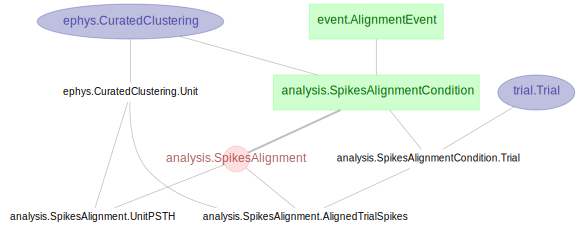

In [14]:
(
    dj.Diagram(analysis)
    + dj.Diagram(event.AlignmentEvent)
    + dj.Diagram(trial.Trial)
    + dj.Diagram(ephys.CuratedClustering)
)

Let's start by creating an analysis configuration - i.e. inserting into ***SpikesAlignmentCondition*** for the `center` event, called `center_button` in the `AlignmentEvent` table.

In [15]:
alignment_key = (event.AlignmentEvent & 'alignment_name = "center_button"').fetch1(
    "KEY"
)
alignment_condition = {
    **clustering_key,
    **alignment_key,
    "trial_condition": "ctrl_center_button",
    "bin_size": 0.2,
}
analysis.SpikesAlignmentCondition.insert1(alignment_condition, skip_duplicates=True)
alignment_condition.pop("bin_size")
analysis.SpikesAlignmentCondition.Trial.insert(
    (analysis.SpikesAlignmentCondition * ctrl_trials & alignment_condition).proj(),
    skip_duplicates=True,
)

With the steps above, we have created a new spike alignment condition for analysis, named `ctrl_center_button`, which retains all spiking information related to control trials during which the center button was pressed.

In [16]:
analysis.SpikesAlignmentCondition.Trial()

subject,session_datetime,insertion_number,paramset_idx,alignment_name,trial_condition user-friendly name of condition,trial_id trial number (1-based indexing)
subject6,2021-01-15 11:16:38,0,0,center_button,ctrl_center_button,2
subject6,2021-01-15 11:16:38,0,0,center_button,ctrl_center_button,3
subject6,2021-01-15 11:16:38,0,0,center_button,ctrl_center_button,4
subject6,2021-01-15 11:16:38,0,0,center_button,ctrl_center_button,7
subject6,2021-01-15 11:16:38,0,0,center_button,ctrl_center_button,8
subject6,2021-01-15 11:16:38,0,0,center_button,ctrl_center_button,9
subject6,2021-01-15 11:16:38,0,0,center_button,ctrl_center_button,13
subject6,2021-01-15 11:16:38,0,0,center_button,ctrl_center_button,14
subject6,2021-01-15 11:16:38,0,0,center_button,ctrl_center_button,15
subject6,2021-01-15 11:16:38,0,0,center_button,ctrl_center_button,16


Now, let's create another set for the stimulus condition.

In [17]:
stim_trials = trial.Trial & clustering_key & 'trial_type = "stim"'
alignment_condition = {
    **clustering_key,
    **alignment_key,
    "trial_condition": "stim_center_button",
    "bin_size": 0.2,
}
analysis.SpikesAlignmentCondition.insert1(alignment_condition, skip_duplicates=True)
alignment_condition.pop("bin_size")
analysis.SpikesAlignmentCondition.Trial.insert(
    (analysis.SpikesAlignmentCondition * stim_trials & alignment_condition).proj(),
    skip_duplicates=True,
)

We can compare conditions in the `SpikesAlignmentCondition` table.

In [18]:
analysis.SpikesAlignmentCondition()

subject,session_datetime,insertion_number,paramset_idx,alignment_name,trial_condition user-friendly name of condition,condition_description,bin_size bin-size (in second) used to compute the PSTH
subject6,2021-01-15 11:16:38,0,0,center_button,ctrl_center_button,,0.2
subject6,2021-01-15 11:16:38,0,0,center_button,stim_center_button,,0.2


In [19]:
analysis.SpikesAlignmentCondition.Trial & 'trial_condition = "stim_center_button"'

subject,session_datetime,insertion_number,paramset_idx,alignment_name,trial_condition user-friendly name of condition,trial_id trial number (1-based indexing)
subject6,2021-01-15 11:16:38,0,0,center_button,stim_center_button,1
subject6,2021-01-15 11:16:38,0,0,center_button,stim_center_button,5
subject6,2021-01-15 11:16:38,0,0,center_button,stim_center_button,6
subject6,2021-01-15 11:16:38,0,0,center_button,stim_center_button,10
subject6,2021-01-15 11:16:38,0,0,center_button,stim_center_button,11
subject6,2021-01-15 11:16:38,0,0,center_button,stim_center_button,12
subject6,2021-01-15 11:16:38,0,0,center_button,stim_center_button,17
subject6,2021-01-15 11:16:38,0,0,center_button,stim_center_button,18
subject6,2021-01-15 11:16:38,0,0,center_button,stim_center_button,19
subject6,2021-01-15 11:16:38,0,0,center_button,stim_center_button,21


## Computation

Now let's run the computation on these.

In [20]:
analysis.SpikesAlignment.populate(display_progress=True)

SpikesAlignment: 100%|██████████| 2/2 [00:16<00:00,  8.24s/it]


## Visualize

We can visualize the results with the `plot` function with our keys.

In [21]:
clustering_key = (
    ephys.CuratedClustering
    & {
        "subject": "subject6",
        "session_datetime": "2021-01-15 11:16:38",
        "insertion_number": 0,
    }
).fetch1("KEY")
alignment_key = (event.AlignmentEvent & 'alignment_name = "center_button"').fetch1(
    "KEY"
)

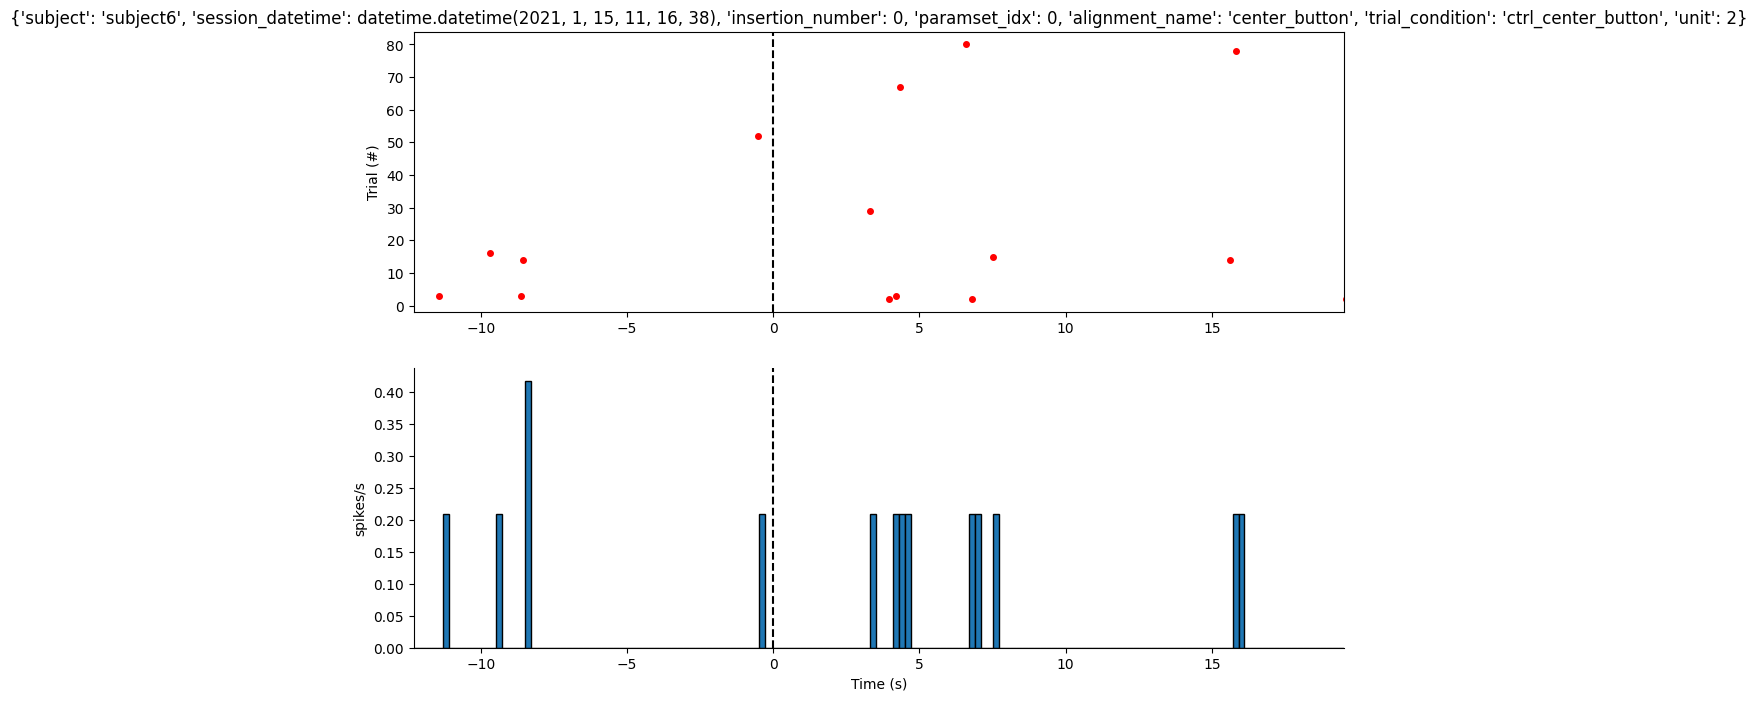

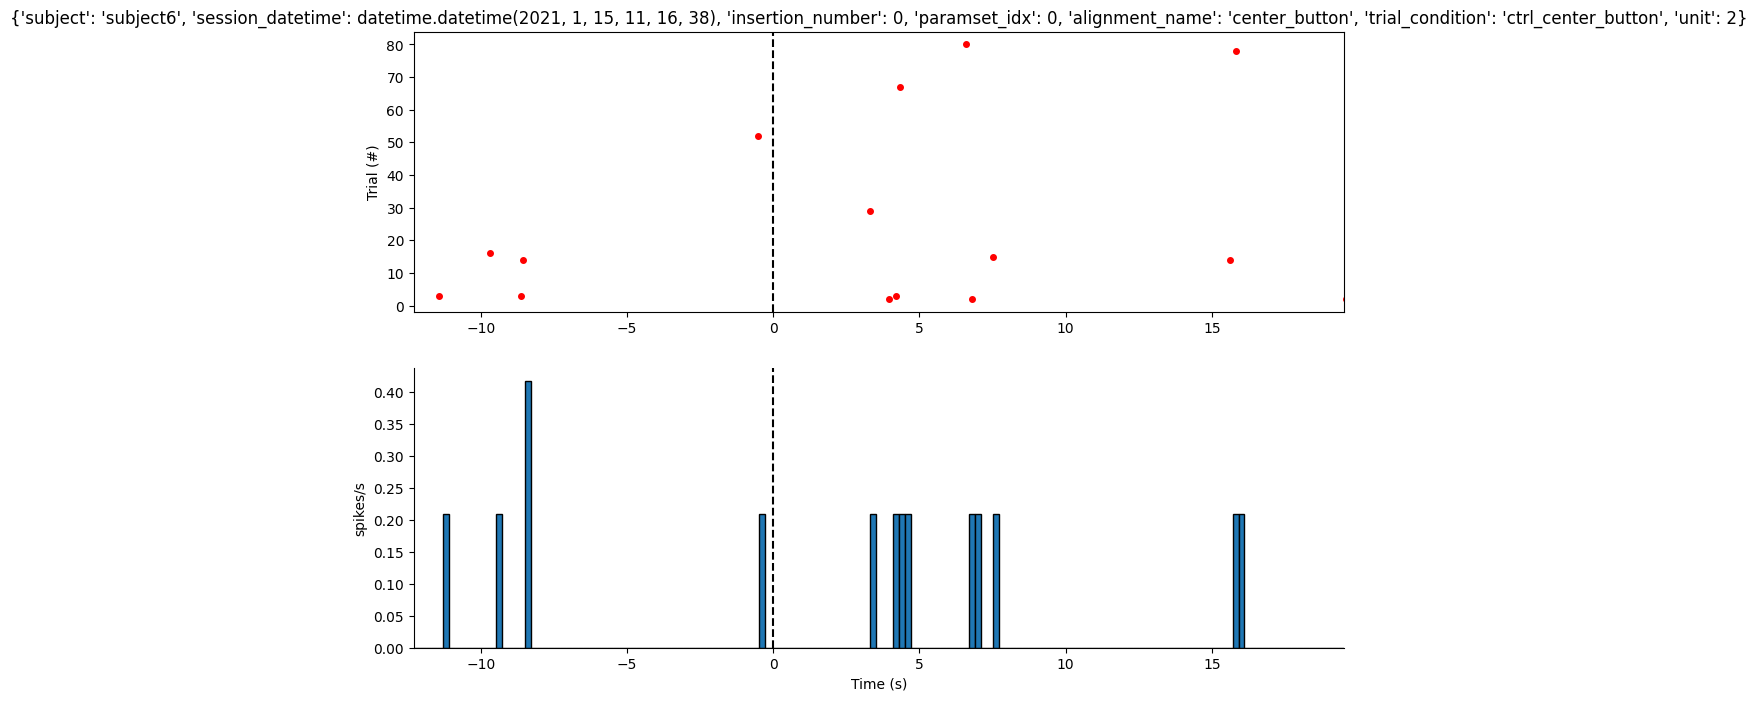

In [22]:
alignment_condition = {
    **clustering_key,
    **alignment_key,
    "trial_condition": "ctrl_center_button",
}
analysis.SpikesAlignment().plot(alignment_condition, unit=2)

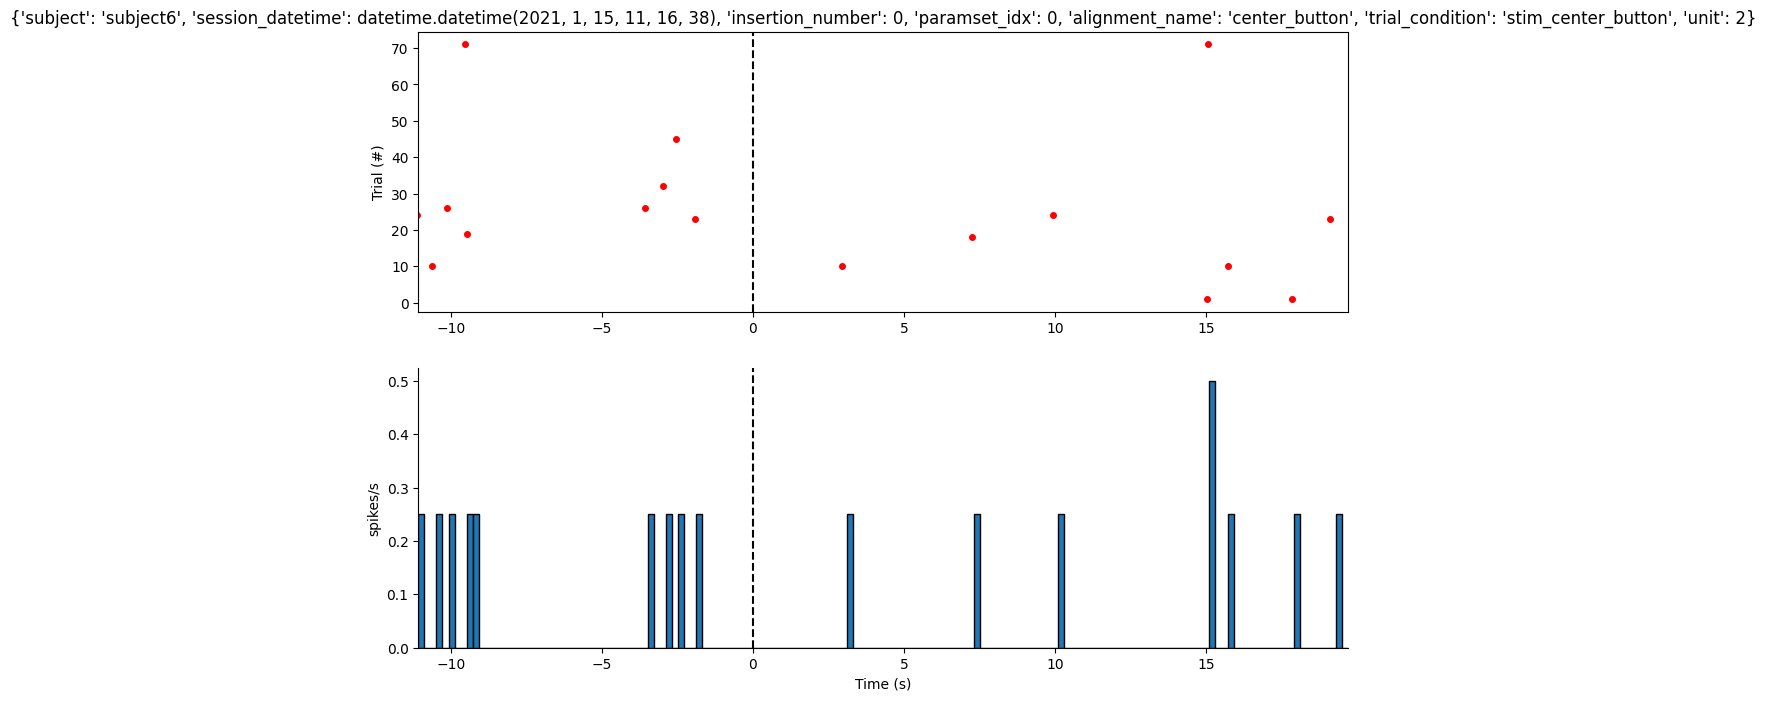

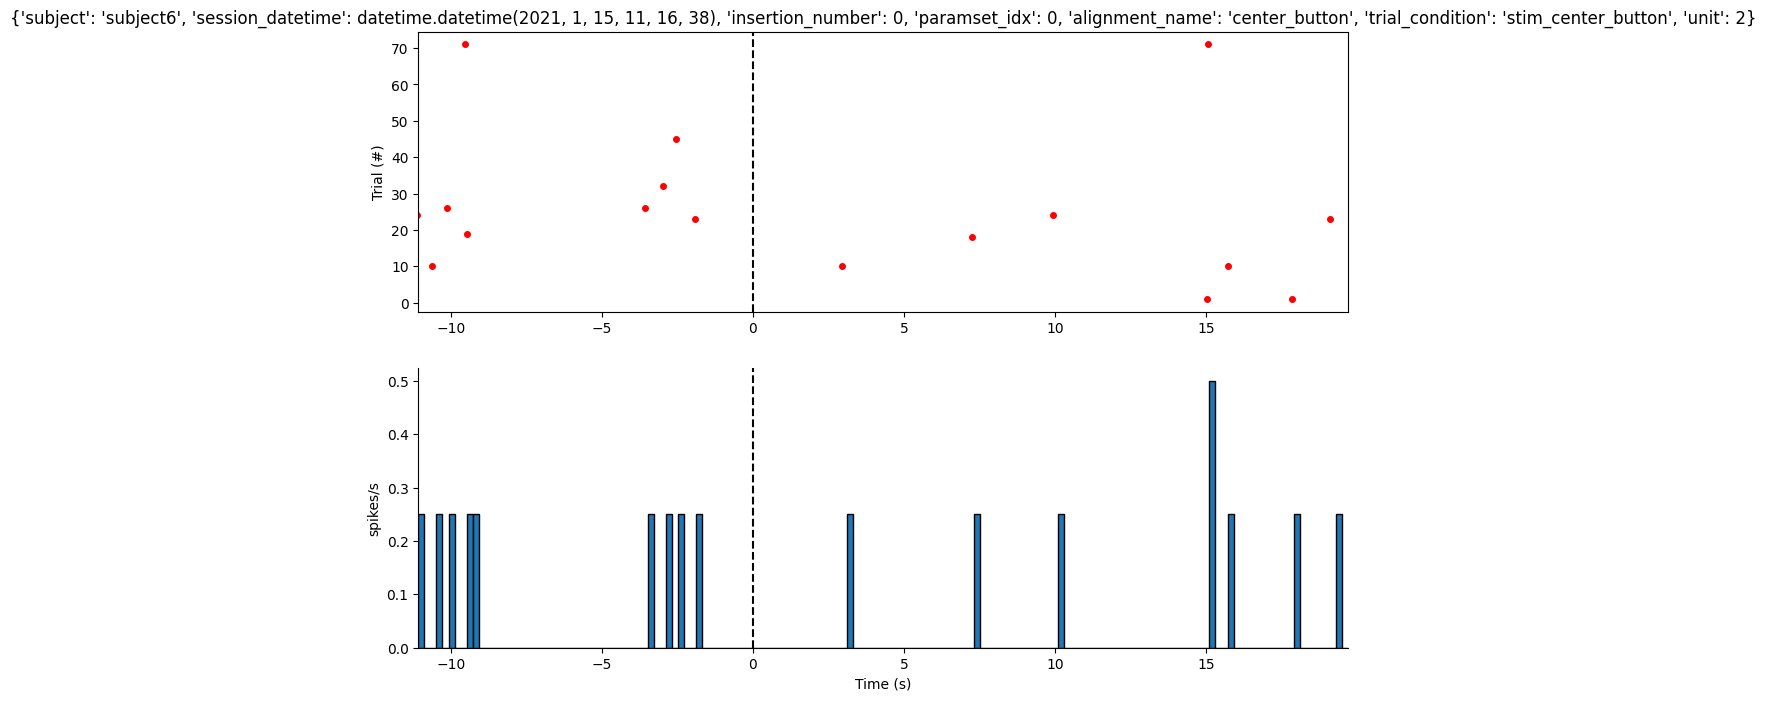

In [23]:
alignment_condition = {
    **clustering_key,
    **alignment_key,
    "trial_condition": "stim_center_button",
}
analysis.SpikesAlignment().plot(alignment_condition, unit=2)